## Imports

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader

In [2]:
import matplotlib.pyplot as plt

In [3]:
from PIL import Image

In [4]:
import sys
sys.path.append("../figures")

from where_copie import MNIST, WhereShift, TransformDico, RetinaFill, RetinaBackground, RetinaMask, RetinaWhiten 

In [5]:
from main import init
args = init(filename='../data/2019-06-12')
args

{'w': 28,
 'minibatch_size': 100,
 'train_batch_size': 50000,
 'test_batch_size': 10000,
 'noise_batch_size': 1000,
 'mean': 0.1307,
 'std': 0.3081,
 'N_pic': 128,
 'offset_std': 30,
 'offset_max': 34,
 'noise': 1.0,
 'contrast': 0.7,
 'sf_0': 0.1,
 'B_sf': 0.1,
 'N_theta': 6,
 'N_azimuth': 24,
 'N_eccentricity': 10,
 'N_phase': 2,
 'rho': 1.41,
 'bias_deconv': True,
 'p_dropout': 0.0,
 'dim1': 1000,
 'dim2': 1000,
 'lr': 0.005,
 'do_adam': True,
 'bn1_bn_momentum': 0.5,
 'bn2_bn_momentum': 0.5,
 'momentum': 0.3,
 'epochs': 60,
 'num_processes': 1,
 'no_cuda': True,
 'log_interval': 100,
 'verbose': 1,
 'filename': '../data/2019-06-05',
 'seed': 2019,
 'N_cv': 10,
 'do_compute': True,
 'what_offset_std': 5.0,
 'what_offset_max': 15}

## Création rétine

In [6]:
from retina_copie import Retina
retina = Retina(args)

../tmp/retina_6_24_10_2_1.41_128_dico.npy
Fichier retina_dico charge avec succes
../tmp/colliculus_transform_6_24_10_2_1.41_128_dico.npy
Fichier retina_dico charge avec succes
../tmp/retina_6_24_10_2_1.41_128_transform.npy
Fichier retina_transform charge avec succes
../tmp/retina_6_24_10_2_1.41_128_inverse_transform.npy
Fichier retina_inverse_transform charge avec succes


## inverse_transform_dico

### Récupération d'un retina_features

In [7]:
import math

In [8]:
i_offset = -18 #None #
j_offset = 18 #None #

In [9]:
args.contrast = 0.5

In [10]:
transform=transforms.Compose([
                               RetinaFill(N_pic=args.N_pic),
                               #WhereShift(args, theta=3*math.pi/4), 
                               #WhereShift(args, radius = 18), 
                               WhereShift(args, i_offset=i_offset, j_offset=j_offset),
                               RetinaBackground( contrast=args.contrast,
                                                 noise=args.noise,
                                                 sf_0=args.sf_0,
                                                 B_sf=args.B_sf),
                               RetinaMask(N_pic=args.N_pic),
                               RetinaWhiten(N_pic=args.N_pic),
                               TransformDico(retina),
                               #Normalize()
                           ])

In [11]:
dataset_train = MNIST('../data',
                        train=True,
                        download=True,
                        transform=transform,
                        #target_transform = target_transform,
                        )

In [12]:
train_loader = torch.utils.data.DataLoader(dataset_train,
                                         batch_size=args.minibatch_size,
                                         shuffle=True)

In [13]:
import datetime
debut = datetime.datetime.now()

data, label = next(iter(train_loader))

fin = datetime.datetime.now()
print("Duree d'execution", fin-debut)

Duree d'execution 0:00:16.083628


In [14]:
index_liste = 2
retina_features, label_features = data[index_liste], label[index_liste]

In [15]:
print(retina_features.shape)
print(label_features)

torch.Size([2880])
tensor(0)


### Codage de inverse_transform_dico

In [16]:
def affiche(donnees, titre, c_a, commentaire=None):
    if c_a:
        if commentaire:
            print(commentaire)
        plt.imshow(donnees)
        plt.title(titre)
        plt.show()

In [17]:
type_affichage = 2 # 1 affichage habituel, 2 affichage graduel, 3 affichage par azimuth

In [18]:
def inverse_transform_dico(retina_features):
    N_X, N_Y = args.N_pic, args.N_pic
    rebuild_pixel_fullfield = np.zeros((N_X, N_Y))
    indice_coefficient = 0
    for i_theta in range(args.N_theta):
        for i_azimuth in range(args.N_azimuth):
            inter_rebuild_pixel_fullfield = np.zeros((N_X, N_Y))
            for i_eccentricity in range(args.N_eccentricity):
                for i_phase in range(args.N_phase):
                    fenetre_filtre = retina.retina_dico[i_theta][i_phase][i_eccentricity][i_azimuth]
                    dimension_filtre = int(fenetre_filtre.shape[0] ** (1 / 2))
                    fenetre_filtre = fenetre_filtre.reshape((dimension_filtre, dimension_filtre))
                    coefficient = float(retina_features[indice_coefficient])
                    #print("coeff", type(coefficient))
                    #print("filtre", type(fenetre_filtre))
                    morceau_image_reconstituee = coefficient * fenetre_filtre
                    
                    if type_affichage == 1:
                        c_a = i_azimuth == 16 and i_theta == 0 and i_phase == 0  # conditions d'affichage
                    else : c_a = False                    
                    
                    #il faut a present placer le morceau au bon endroit de l'image
                    
                    ecc_max = .8
                    ecc = ecc_max * (1 / args.rho) ** (args.N_eccentricity - i_eccentricity)
                    r = np.sqrt(N_X ** 2 + N_Y ** 2) / 2 * ecc  # radius
                    psi = (i_azimuth + 1 * (i_eccentricity % 2) * .5) * np.pi * 2 / args.N_azimuth
                    x = int(N_X / 2 + r * np.cos(psi))
                    y = int(N_Y / 2 + r * np.sin(psi))

                    r = dimension_filtre // 2
                    
                    #if c_a :
                    #    print("x, y, r", x,y,r)

                    #print(c_a)    
                    #if c_a :
                    #    print(coefficient)
                    
                    affiche(fenetre_filtre, "fenetre_filtre", c_a)
                    affiche(morceau_image_reconstituee, "morceau_image_reconstituee", c_a)

                    fenetre_image = inter_rebuild_pixel_fullfield[int(x - r):int(x + r), int(y - r):int(y + r)]
                    
                    #if c_a :
                    #    print(np.ravel(fenetre_image).shape, np.ravel(fenetre_filtre).shape)
                        
                    if np.ravel(fenetre_image).shape == np.ravel(fenetre_filtre).shape:
                        inter_rebuild_pixel_fullfield[int(x - r):int(x + r), int(y - r):int(y + r)] += morceau_image_reconstituee
                    
                    if np.ravel(fenetre_image).shape != np.ravel(fenetre_filtre).shape:
                        fenetre_image = np.zeros((dimension_filtre, dimension_filtre))

                        if y + r > args.N_pic:  # ca depasse à droite
                            morceau_interne_fullfield = inter_rebuild_pixel_fullfield[x - r:x + r, y - r:args.N_pic]
                            morceau_externe_fullfield = inter_rebuild_pixel_fullfield[x - r:x + r, 0:y + r - args.N_pic]  # qu'on est donc alle chercher ailleurs dans l'image
                            nb_lignes = morceau_externe_fullfield.shape[0]
                            if nb_lignes == 2 * r:  # ce n'est pas un coin
                                #print("rebuild1", rebuild_pixel_fullfield[0:x + r, 0:r - args.N_pic + y].shape)
                                #print("reconstit1", morceau_image_reconstituee[r - x:2 * r, r + args.N_pic - y:2 * r].shape)
                                inter_rebuild_pixel_fullfield[x - r:x + r, y - r:args.N_pic] += morceau_image_reconstituee[0:2 * r, 0:r + args.N_pic - y]
                                #affiche(inter_rebuild_pixel_fullfield, "Construction rebuild_pixel_fullfield : ajout partie gauche", c_a)
                                inter_rebuild_pixel_fullfield[x - r:x + r, 0:y + r - args.N_pic] += morceau_image_reconstituee[0:2 * r, r + args.N_pic - y:2 * r]
                                #affiche(inter_rebuild_pixel_fullfield, "Construction rebuild_pixel_fullfield : ajout partie droite", c_a)
                    

                            elif x - r < 0:  # contient le coin superieur droit
                                #print("rebuild2", rebuild_pixel_fullfield[0:x + r, 0:r - args.N_pic + y].shape)
                                #print("reconstit2", morceau_image_reconstituee[r - x:2 * r, r + args.N_pic - y:2 * r].shape)
                                inter_rebuild_pixel_fullfield[0:x + r, 0:r - args.N_pic + y] += morceau_image_reconstituee[r - x:2 * r, r + args.N_pic - y:2 * r]
                                #affiche(inter_rebuild_pixel_fullfield, "Construction rebuild_pixel_fullfield : ajout bas droit", c_a)
                                inter_rebuild_pixel_fullfield[args.N_pic - r + x:args.N_pic, 0:y + r - args.N_pic] += morceau_image_reconstituee[0:r - x, r - y + args.N_pic:2 * r]
                                #affiche(inter_rebuild_pixel_fullfield, "Construction rebuild_pixel_fullfield : ajout haut droit", c_a)
                    

                            elif x + r > args.N_pic:  # contient le coin inferieur droit

                                inter_rebuild_pixel_fullfield[x - r:x + r, 0:y + r - args.N_pic] += morceau_image_reconstituee[0:nb_lignes, r + args.N_pic - y:2 * r]
                                #affiche(inter_rebuild_pixel_fullfield, "Construction rebuild_pixel_fullfield : ajout haut droit", c_a)
                                #print("rebuild3", rebuild_pixel_fullfield[0:x + r - args.N_pic, 0:y + r - args.N_pic].shape)
                                #print("reconstit3", morceau_image_reconstituee[0:nb_lignes, r + args.N_pic - y:2 * r].shape)
                                inter_rebuild_pixel_fullfield[0:x + r - args.N_pic, 0:y + r - args.N_pic] += morceau_image_reconstituee[r - x + args.N_pic:2 * r, r - y + args.N_pic:2 * r]
                                #affiche(inter_rebuild_pixel_fullfield, "Construction rebuild_pixel_fullfield : ajout bas droit", c_a)


                        elif y - r < 0:  # ca depasse a gauche
                            morceau_externe_fullfield = inter_rebuild_pixel_fullfield[x - r:x + r, args.N_pic - r + y:args.N_pic]
                            morceau_interne_fullfield = inter_rebuild_pixel_fullfield[x - r:x + r, 0:y + r]
                            nb_lignes = morceau_externe_fullfield.shape[0]
                            if nb_lignes == 2 * r:  # ce n'est pas un coin
                                inter_rebuild_pixel_fullfield[x - r:x + r, args.N_pic - r + y:args.N_pic] += morceau_image_reconstituee[0:2 * r, 0:r - y]
                                #affiche(inter_rebuild_pixel_fullfield, "Construction rebuild_pixel_fullfield : ajout partie gauche", c_a)
                                inter_rebuild_pixel_fullfield[x - r:x + r, 0:y + r] += morceau_image_reconstituee[0:2 * r, r - y:2 * r]
                                #affiche(inter_rebuild_pixel_fullfield, "Construction rebuild_pixel_fullfield : ajout partie droite", c_a)
                            
                            elif x - r < 0:  # contient le coin superieur gauche
                                inter_rebuild_pixel_fullfield[0:x + r, args.N_pic - r + y:args.N_pic] += morceau_image_reconstituee[r - x:2 * r, 0:r - y]
                                #affiche(inter_rebuild_pixel_fullfield, "Construction rebuild_pixel_fullfield : ajout bas gauche", c_a)
                                inter_rebuild_pixel_fullfield[args.N_pic - r + x:args.N_pic, args.N_pic - r + y:args.N_pic] += morceau_image_reconstituee[0:r - x, 0:r - y]
                                #affiche(inter_rebuild_pixel_fullfield, "Construction rebuild_pixel_fullfield : ajout haut gauche", c_a)
                                
                            elif x + r > args.N_pic:  # contient le coin inferieur gauche
                                inter_rebuild_pixel_fullfield[0:x + r - args.N_pic, args.N_pic - r + y:args.N_pic] += morceau_image_reconstituee[r + args.N_pic - x:2 * r, 0:r - y]
                                #affiche(inter_rebuild_pixel_fullfield, "Construction rebuild_pixel_fullfield : ajout bas gauche", c_a)
                                inter_rebuild_pixel_fullfield[x - r:x + r, args.N_pic - r + y:args.N_pic] += morceau_image_reconstituee[0:r + args.N_pic - x, 0:r - y]
                                #affiche(inter_rebuild_pixel_fullfield, "Construction rebuild_pixel_fullfield : ajout haut gauche", c_a)
                                
                                
                        if x - r < 0:  # ca depasse en haut
                            morceau_externe_fullfield = inter_rebuild_pixel_fullfield[args.N_pic - r + x:args.N_pic, y - r:y + r]
                            morceau_interne_fullfield = inter_rebuild_pixel_fullfield[0:r + x, y - r:y + r]
                            nb_colonnes = morceau_externe_fullfield.shape[1]
                            if nb_colonnes == 2 * r:  # ce n'est pas un coin
                                inter_rebuild_pixel_fullfield[0:r + x, y - r:y + r] += morceau_image_reconstituee[r - x:2 * r, 0:2 * r]
                                #affiche(inter_rebuild_pixel_fullfield, "Construction rebuild_pixel_fullfield : ajout partie basse", c_a)
                                inter_rebuild_pixel_fullfield[args.N_pic - r + x:args.N_pic, y - r:y + r] += morceau_image_reconstituee[0:r - x, 0:2 * r]
                                #affiche(inter_rebuild_pixel_fullfield, "Construction rebuild_pixel_fullfield : ajout partie haute", c_a)
                    
                            elif y - r < 0:  # contient le coin superieur gauche
                                inter_rebuild_pixel_fullfield[args.N_pic - r + x:args.N_pic, 0:y + r] += morceau_image_reconstituee[0:r - x, r - y:2 * r]
                                #affiche(inter_rebuild_pixel_fullfield, "Construction rebuild_pixel_fullfield : ajout haut droit", c_a)
                                inter_rebuild_pixel_fullfield[0:r + x, 0:y + r] += morceau_image_reconstituee[r - x:2 * r, r - y:2 * r]
                                #affiche(inter_rebuild_pixel_fullfield, "Construction rebuild_pixel_fullfield : ajout bas droit", c_a)
                            
                            elif y + r > args.N_pic:  # contient le coin superieur droit
                                inter_rebuild_pixel_fullfield[args.N_pic - r + x:args.N_pic, y - r:y + r] += morceau_image_reconstituee[0:r - x, 0:r + args.N_pic - y]
                                #affiche(inter_rebuild_pixel_fullfield, "Construction rebuild_pixel_fullfield : ajout haut gauche", c_a)
                                inter_rebuild_pixel_fullfield[0:r + x, y - r:y + r] += morceau_image_reconstituee[r - x:2 * r, 0:nb_colonnes]
                                #affiche(inter_rebuild_pixel_fullfield, "Construction rebuild_pixel_fullfield : ajout bas gauche", c_a)
                                

                        elif x + r > args.N_pic:  # ca depasse en bas
                            morceau_interne_fullfield = inter_rebuild_pixel_fullfield[x - r:args.N_pic, y - r:y + r]
                            morceau_externe_fullfield = inter_rebuild_pixel_fullfield[0:r - args.N_pic + x, y - r:y + r]
                            nb_colonnes = morceau_externe_fullfield.shape[1]
                            if nb_colonnes == 2 * r:  # ce n'est pas un coin
                                inter_rebuild_pixel_fullfield[x - r:args.N_pic, y - r:y + r] += morceau_image_reconstituee[0:args.N_pic - x + r, 0:2 * r]
                                affiche(inter_rebuild_pixel_fullfield, "Construction rebuild_pixel_fullfield : ajout partie gauche", c_a)
                                inter_rebuild_pixel_fullfield[0:r - args.N_pic + x, y - r:y + r] += morceau_image_reconstituee[args.N_pic - x + r:2 * r, 0:2 * r]
                                affiche(inter_rebuild_pixel_fullfield, "Construction rebuild_pixel_fullfield : ajout partie droite", c_a)

                            elif y - r < 0:  # contient le coin inferieur gauche
                                inter_rebuild_pixel_fullfield[x - r:args.N_pic, 0:r + y] += morceau_image_reconstituee[0:args.N_pic - x + r, r - y:2 * r]
                                affiche(inter_rebuild_pixel_fullfield, "Construction rebuild_pixel_fullfield : ajout haut droit", c_a)
                                inter_rebuild_pixel_fullfield[0:r - args.N_pic + x, 0:r + y] += morceau_image_reconstituee[args.N_pic - x + r:2 * r, r - y:2 * r]
                                affiche(inter_rebuild_pixel_fullfield, "Construction rebuild_pixel_fullfield : ajout bas droit", c_a)

                            elif y + r > args.N_pic:  # contient le coin inferieur droit
                                inter_rebuild_pixel_fullfield[x - r:args.N_pic, y - r:y + r] += morceau_image_reconstituee[0:args.N_pic - x + r, 0:nb_colonnes]
                                affiche(inter_rebuild_pixel_fullfield, "Construction rebuild_pixel_fullfield : ajout haut gauche", c_a)
                                inter_rebuild_pixel_fullfield[0:r - args.N_pic + x, y - r:y + r] += morceau_image_reconstituee[args.N_pic - x + r:2 * r, 0:nb_colonnes]
                                affiche(inter_rebuild_pixel_fullfield, "Construction rebuild_pixel_fullfield : ajout bas gauche", c_a)

                    affiche(inter_rebuild_pixel_fullfield, "Image reconstituee apres l'application de ce filtre (et de tous les precedents de mêm azimuth)", c_a)
                    c_a = False
                    
                    if type_affichage == 2 :
                        if indice_coefficient%100 == 0 :
                            print("coefficient numero", indice_coefficient)
                            c_a = True
                    
                    affiche(rebuild_pixel_fullfield + inter_rebuild_pixel_fullfield, "rebuild_pixel_fullfield en cours de construction", c_a)
                    c_a = False
                    indice_coefficient +=1
        
            if type_affichage==3 :
                print("coefficient numero", indice_coefficient)
                c_a = True      
            affiche(inter_rebuild_pixel_fullfield, "rebuild_pixel_fullfield en cours de construction", c_a)
            c_a = False
            rebuild_pixel_fullfield += inter_rebuild_pixel_fullfield
                    
    c_a = True
    affiche(rebuild_pixel_fullfield, "image finale", c_a)
    
    return rebuild_pixel_fullfield

coefficient numero 0


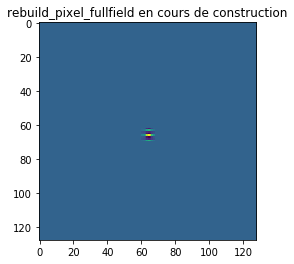

coefficient numero 100


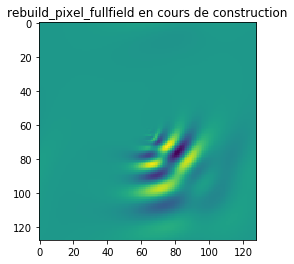

coefficient numero 200


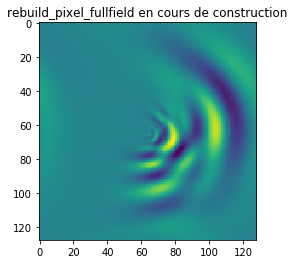

coefficient numero 300


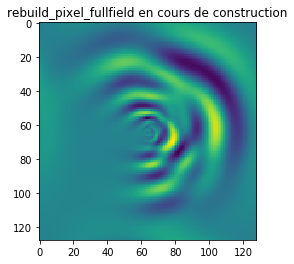

coefficient numero 400


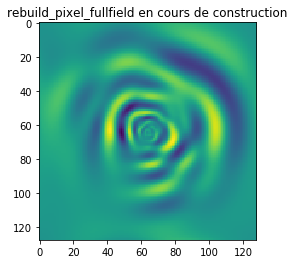

coefficient numero 500


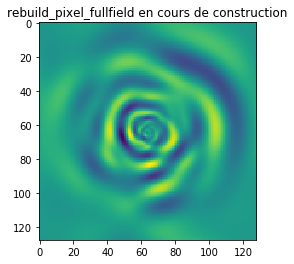

coefficient numero 600


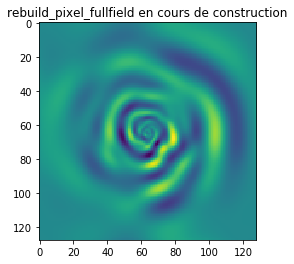

coefficient numero 700


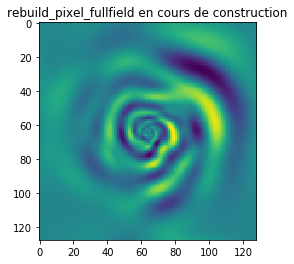

coefficient numero 800


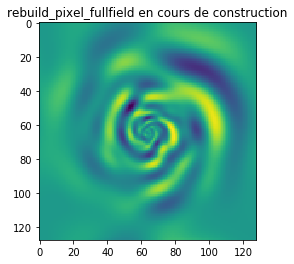

coefficient numero 900


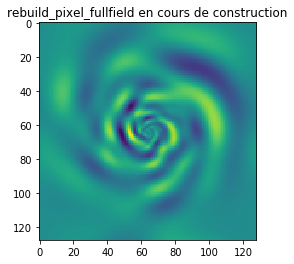

coefficient numero 1000


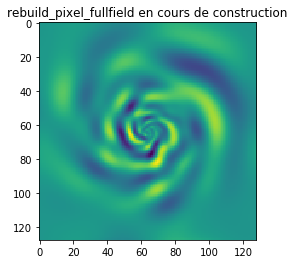

coefficient numero 1100


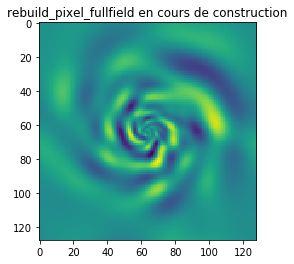

coefficient numero 1200


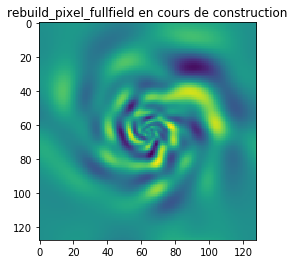

coefficient numero 1300


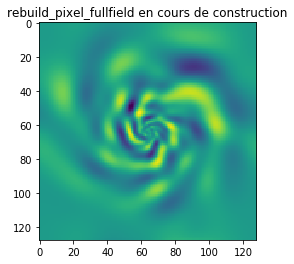

coefficient numero 1400


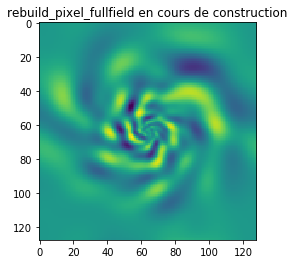

coefficient numero 1500


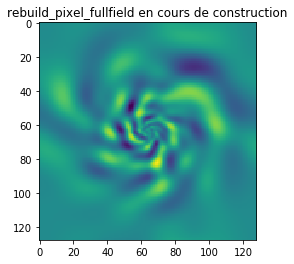

coefficient numero 1600


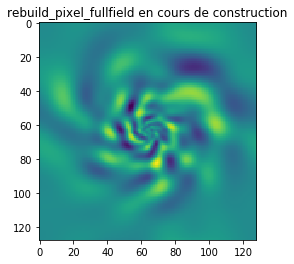

coefficient numero 1700


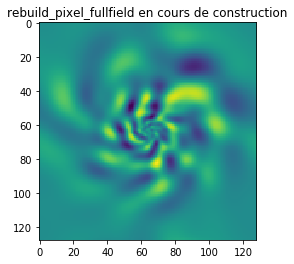

coefficient numero 1800


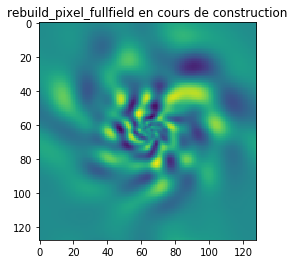

coefficient numero 1900


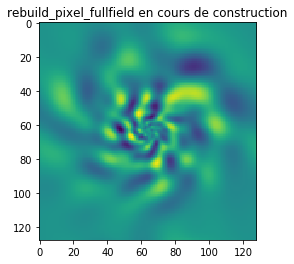

coefficient numero 2000


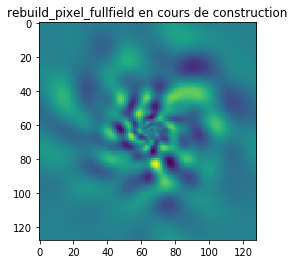

coefficient numero 2100


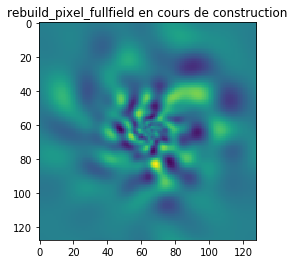

coefficient numero 2200


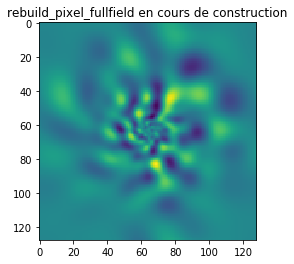

coefficient numero 2300


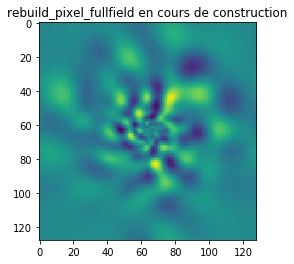

coefficient numero 2400


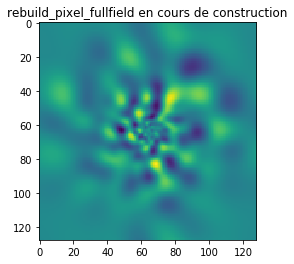

coefficient numero 2500


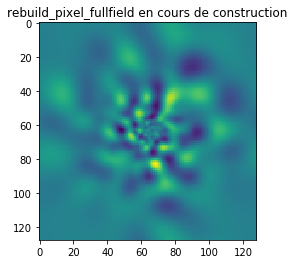

coefficient numero 2600


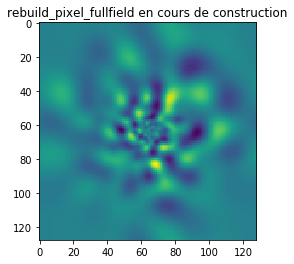

coefficient numero 2700


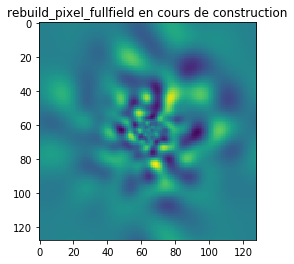

coefficient numero 2800


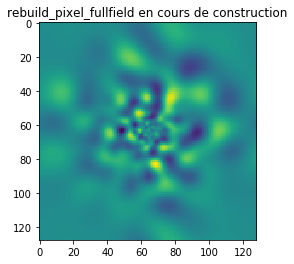

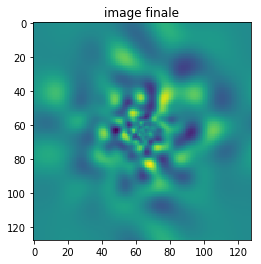

In [19]:
image_rebuild = inverse_transform_dico(retina_features)

## Zone expérimentale

### Imitation matrice retina_transform

In [20]:


from display import pe

theta, azimuth, eccentricity, phase, pic = 3, 4, 5, 2, 2

testretina = np.zeros((theta, azimuth, eccentricity, phase, pic**2))

from LogGabor import LogGabor
lg = LogGabor(pe=pe)
lg.set_size((pic, pic))

nb = 0 
for i_theta in range(theta):
    for i_azimuth in range(azimuth):
        for i_eccentricity in range(eccentricity):
            for i_phase in range(phase):
                testretina[i_theta, i_azimuth, i_eccentricity, i_phase, :] = nb 
                nb+=1
                

In [21]:
print(testretina)

[[[[[  0.   0.   0.   0.]
    [  1.   1.   1.   1.]]

   [[  2.   2.   2.   2.]
    [  3.   3.   3.   3.]]

   [[  4.   4.   4.   4.]
    [  5.   5.   5.   5.]]

   [[  6.   6.   6.   6.]
    [  7.   7.   7.   7.]]

   [[  8.   8.   8.   8.]
    [  9.   9.   9.   9.]]]


  [[[ 10.  10.  10.  10.]
    [ 11.  11.  11.  11.]]

   [[ 12.  12.  12.  12.]
    [ 13.  13.  13.  13.]]

   [[ 14.  14.  14.  14.]
    [ 15.  15.  15.  15.]]

   [[ 16.  16.  16.  16.]
    [ 17.  17.  17.  17.]]

   [[ 18.  18.  18.  18.]
    [ 19.  19.  19.  19.]]]


  [[[ 20.  20.  20.  20.]
    [ 21.  21.  21.  21.]]

   [[ 22.  22.  22.  22.]
    [ 23.  23.  23.  23.]]

   [[ 24.  24.  24.  24.]
    [ 25.  25.  25.  25.]]

   [[ 26.  26.  26.  26.]
    [ 27.  27.  27.  27.]]

   [[ 28.  28.  28.  28.]
    [ 29.  29.  29.  29.]]]


  [[[ 30.  30.  30.  30.]
    [ 31.  31.  31.  31.]]

   [[ 32.  32.  32.  32.]
    [ 33.  33.  33.  33.]]

   [[ 34.  34.  34.  34.]
    [ 35.  35.  35.  35.]]

   [[ 36.  36.  36.  3

In [22]:
testretina2 = testretina ** 2

In [23]:
print(testretina2)
print(testretina2.shape)

[[[[[0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]
    [1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00]]

   [[4.0000e+00 4.0000e+00 4.0000e+00 4.0000e+00]
    [9.0000e+00 9.0000e+00 9.0000e+00 9.0000e+00]]

   [[1.6000e+01 1.6000e+01 1.6000e+01 1.6000e+01]
    [2.5000e+01 2.5000e+01 2.5000e+01 2.5000e+01]]

   [[3.6000e+01 3.6000e+01 3.6000e+01 3.6000e+01]
    [4.9000e+01 4.9000e+01 4.9000e+01 4.9000e+01]]

   [[6.4000e+01 6.4000e+01 6.4000e+01 6.4000e+01]
    [8.1000e+01 8.1000e+01 8.1000e+01 8.1000e+01]]]


  [[[1.0000e+02 1.0000e+02 1.0000e+02 1.0000e+02]
    [1.2100e+02 1.2100e+02 1.2100e+02 1.2100e+02]]

   [[1.4400e+02 1.4400e+02 1.4400e+02 1.4400e+02]
    [1.6900e+02 1.6900e+02 1.6900e+02 1.6900e+02]]

   [[1.9600e+02 1.9600e+02 1.9600e+02 1.9600e+02]
    [2.2500e+02 2.2500e+02 2.2500e+02 2.2500e+02]]

   [[2.5600e+02 2.5600e+02 2.5600e+02 2.5600e+02]
    [2.8900e+02 2.8900e+02 2.8900e+02 2.8900e+02]]

   [[3.2400e+02 3.2400e+02 3.2400e+02 3.2400e+02]
    [3.6100e+02 3.6100e+02 3.6

En faisant 0+1+1600+1681+6400+6561 on retrouve bien les 16243 de juste en-dessous

In [24]:
testretina3 = testretina2.sum(axis=(0,3))

In [25]:
print(testretina3)
print(testretina3.shape)

[[[16243. 16243. 16243. 16243.]
  [17239. 17239. 17239. 17239.]
  [18283. 18283. 18283. 18283.]
  [19375. 19375. 19375. 19375.]
  [20515. 20515. 20515. 20515.]]

 [[21703. 21703. 21703. 21703.]
  [22939. 22939. 22939. 22939.]
  [24223. 24223. 24223. 24223.]
  [25555. 25555. 25555. 25555.]
  [26935. 26935. 26935. 26935.]]

 [[28363. 28363. 28363. 28363.]
  [29839. 29839. 29839. 29839.]
  [31363. 31363. 31363. 31363.]
  [32935. 32935. 32935. 32935.]
  [34555. 34555. 34555. 34555.]]

 [[36223. 36223. 36223. 36223.]
  [37939. 37939. 37939. 37939.]
  [39703. 39703. 39703. 39703.]
  [41515. 41515. 41515. 41515.]
  [43375. 43375. 43375. 43375.]]]
(4, 5, 4)


In [26]:
testretina4 = (testretina ** 2).sum(axis=(0,3))

In [27]:
print(testretina4)

[[[16243. 16243. 16243. 16243.]
  [17239. 17239. 17239. 17239.]
  [18283. 18283. 18283. 18283.]
  [19375. 19375. 19375. 19375.]
  [20515. 20515. 20515. 20515.]]

 [[21703. 21703. 21703. 21703.]
  [22939. 22939. 22939. 22939.]
  [24223. 24223. 24223. 24223.]
  [25555. 25555. 25555. 25555.]
  [26935. 26935. 26935. 26935.]]

 [[28363. 28363. 28363. 28363.]
  [29839. 29839. 29839. 29839.]
  [31363. 31363. 31363. 31363.]
  [32935. 32935. 32935. 32935.]
  [34555. 34555. 34555. 34555.]]

 [[36223. 36223. 36223. 36223.]
  [37939. 37939. 37939. 37939.]
  [39703. 39703. 39703. 39703.]
  [41515. 41515. 41515. 41515.]
  [43375. 43375. 43375. 43375.]]]


In [28]:
testcolliculus = testretina4
print(testcolliculus.shape)

(4, 5, 4)


In [29]:
print(testcolliculus.sum(axis=-1)[:, :, None])
print(testcolliculus.sum(axis=-1)[:, :, None].shape)

[[[ 64972.]
  [ 68956.]
  [ 73132.]
  [ 77500.]
  [ 82060.]]

 [[ 86812.]
  [ 91756.]
  [ 96892.]
  [102220.]
  [107740.]]

 [[113452.]
  [119356.]
  [125452.]
  [131740.]
  [138220.]]

 [[144892.]
  [151756.]
  [158812.]
  [166060.]
  [173500.]]]
(4, 5, 1)


In [30]:
testcolliculus /= testcolliculus.sum(axis=-1)[:, :, None]
print(testcolliculus)
print(testcolliculus.shape)

[[[0.25 0.25 0.25 0.25]
  [0.25 0.25 0.25 0.25]
  [0.25 0.25 0.25 0.25]
  [0.25 0.25 0.25 0.25]
  [0.25 0.25 0.25 0.25]]

 [[0.25 0.25 0.25 0.25]
  [0.25 0.25 0.25 0.25]
  [0.25 0.25 0.25 0.25]
  [0.25 0.25 0.25 0.25]
  [0.25 0.25 0.25 0.25]]

 [[0.25 0.25 0.25 0.25]
  [0.25 0.25 0.25 0.25]
  [0.25 0.25 0.25 0.25]
  [0.25 0.25 0.25 0.25]
  [0.25 0.25 0.25 0.25]]

 [[0.25 0.25 0.25 0.25]
  [0.25 0.25 0.25 0.25]
  [0.25 0.25 0.25 0.25]
  [0.25 0.25 0.25 0.25]
  [0.25 0.25 0.25 0.25]]]
(4, 5, 4)


In [31]:
testcolliculus = testcolliculus.reshape((azimuth * eccentricity, pic ** 2))

In [32]:
print(testcolliculus)

[[0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]]


### Visualisation retina_inverse_transform

In [33]:
index_image = 230

In [34]:
avant_inversion = retina.retina_transform_vector
print(avant_inversion.shape)

(2880, 16384)


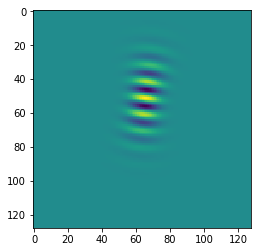

In [35]:
plt.imshow(avant_inversion[index_image].reshape(128,128))

(16384, 2880)


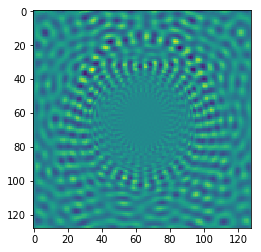

In [36]:
#plt.imshow(retina.retina_inverse_transform)
print(retina.retina_inverse_transform.shape)
#print(retina.retina_inverse_transform)
#plt.show()
image = np.asarray([ retina.retina_inverse_transform[i][index_image] for i in range(retina.retina_inverse_transform.shape[0])])
plt.imshow(image.reshape((128,128)))

In [37]:
image_totale = retina.retina_inverse_transform.sum(axis=1) # ?
print(image_totale.shape)

(16384,)


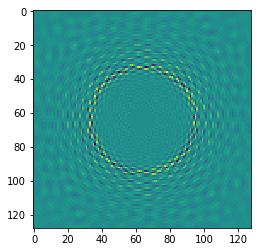

In [38]:
plt.imshow(image_totale.reshape((128,128)))